In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display
import numpy as np
from sklearn.metrics import accuracy_score


import typing
%matplotlib inline

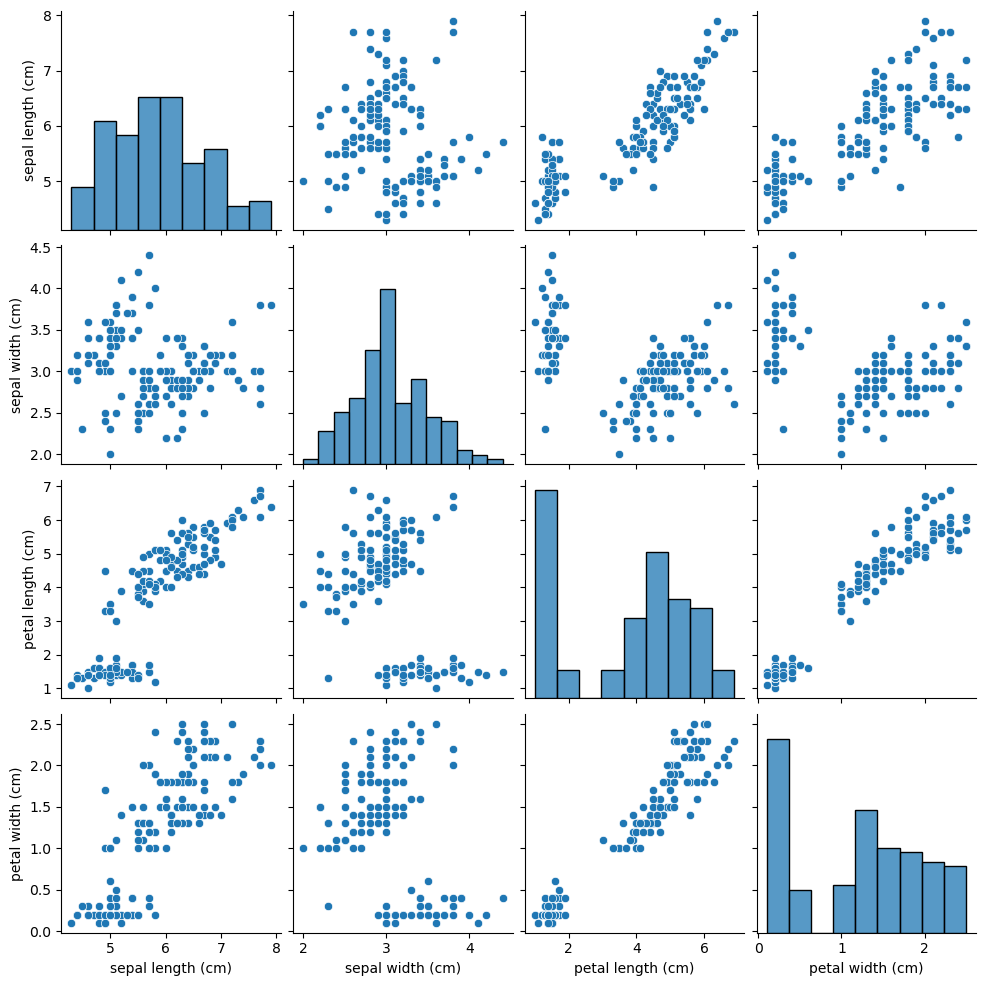

In [2]:
iris_db = datasets.load_iris(as_frame=True)
sn.pairplot(iris_db.data)

In [3]:
iris_db.data.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


We will split the data into train and test sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris_db.data,
    iris_db.target,
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).int()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).int()
y_test = y_test.reshape(-1, 1)
# x_train.shape

Raw training data



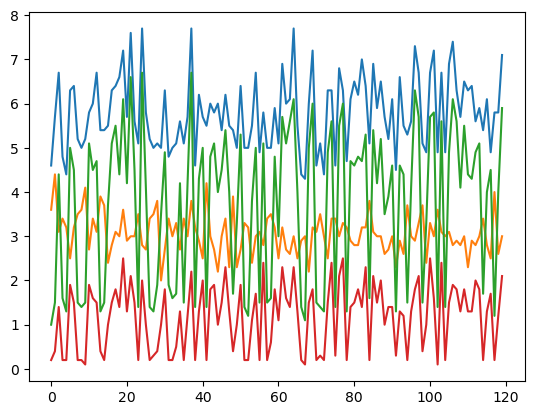

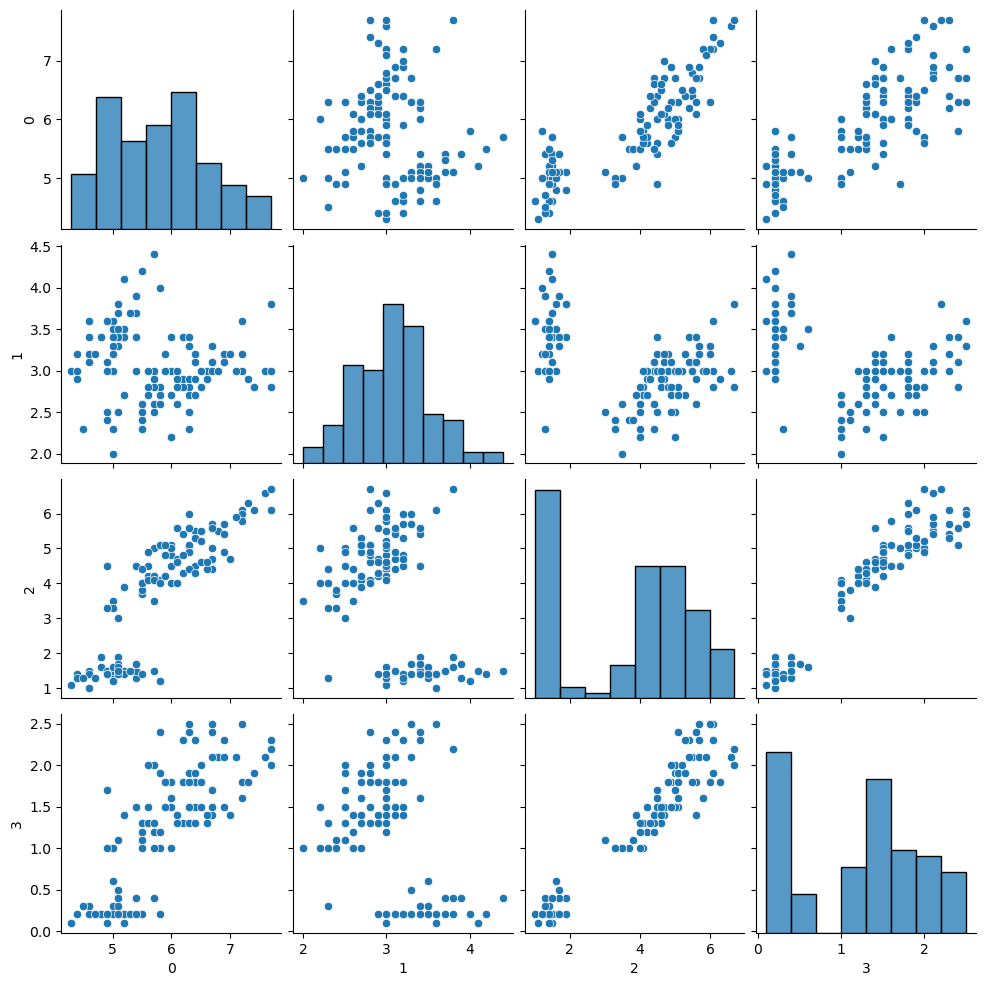

In [5]:
print('Raw training data\n')
plt.plot(x_train)
raw = pd.DataFrame(x_train)
sn.pairplot(raw)

In [6]:
mu_mean = []
sigma_std = []
for k in range(4):
    mu_mean.append(torch.mean(x_train[:,k]))
    sigma_std.append(torch.std(x_train[:,k]))


In [9]:

def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor: 

    for i in range(0,4):
   
        x[:,i] = (x[:,i]- mu[i])/sigma[i]
    return x


# x_train = norm_set(x_train, torch.mean(x_train), torch.std(x_train))
x_train = norm_set(x_train, mu_mean, sigma_std)
# print('Train\n',x_train)
# x_test = norm_set(x_test,torch.mean(x_train), torch.std(x_train))
x_test = norm_set(x_test,mu_mean,sigma_std)
# print('Test\n',x_test)




Normalized data


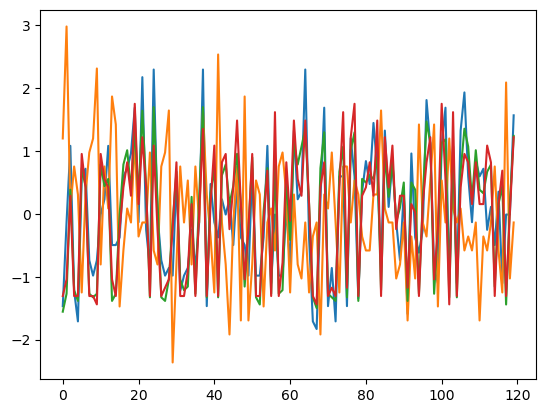

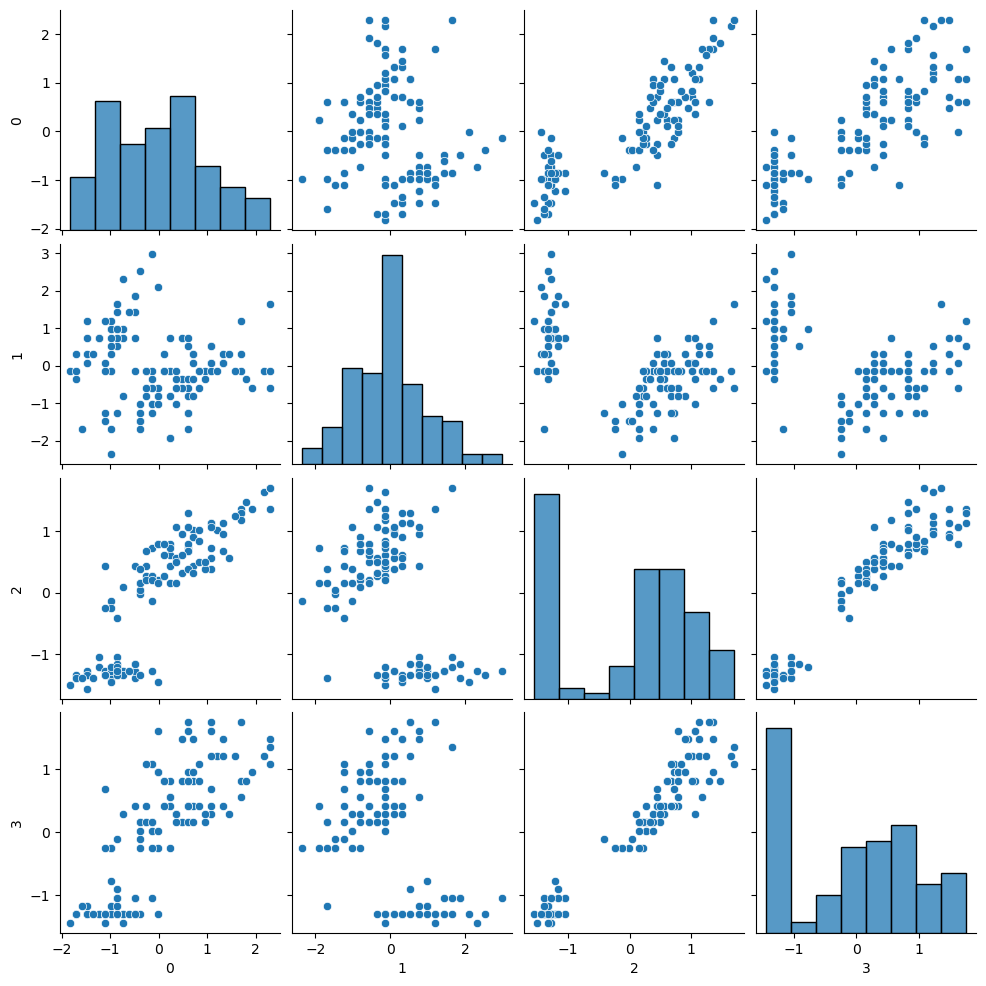

In [11]:
print('Normalized data')
plt.plot(x_train)

normalized = pd.DataFrame(x_train)
sn.pairplot(normalized)

By inspecting the dataset we see that it contains 4 attributes. (`sepal length`, `sepal width`, `petal length`, `petal width`, in centimeters). For simplicity we will focus on the first two.

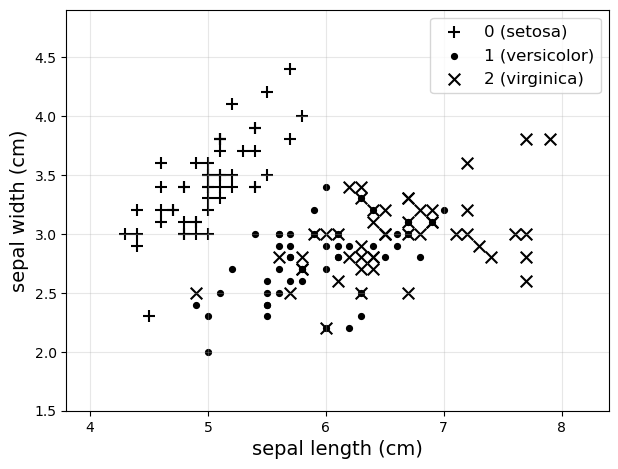

In [12]:
X = iris_db.data.iloc[:, :2] 
Y = iris_db.target
marker_list = ['+', '.', 'x']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

for l in [0, 1, 2]:
  ax.scatter(
      X.loc[Y == l].iloc[:, 0], 
      X.loc[Y == l].iloc[:, 1],
      marker=marker_list[l], 
      s=70, 
      color='black',
      label='{:d} ({:s})'.format(l, iris_db.target_names[l])
      )

ax.legend(fontsize=12)
ax.set_xlabel(iris_db.feature_names[0], fontsize=14)
ax.set_ylabel(iris_db.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5)
ax.set_ylim(X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5)
plt.show()

Is the data linearly separable?

As there are multiple classes, for now we will focus on class 0 (setosa). As such, we modify the `y_train` and `y_test` tensors, so that each label is 1 if the class is setosa and 0 if otherwise.

In [13]:
train_set_1 = x_train[:, :2]
test_set_1 = x_test[:, :2]

# add a feature for bias
train_set_1 = torch.cat([train_set_1, torch.ones(train_set_1.shape[0], 1)], dim=1)
test_set_1 = torch.cat([test_set_1, torch.ones(test_set_1.shape[0], 1)], dim=1)

setosa_train = (y_train == 0).int()
setosa_test = (y_test == 0).int()

In [14]:
# setosa_train
# x_train[:,:2]
# print(y_test)
# print(setosa_test)

## 1. Sigmoid function
With logistic regression the values we want to predict are now discrete classes, not continuous variables. In other words, logistic regression is for classification tasks. In the binary classification problem we have classes $0$ and $1$, e.g. classifying email as spam or not spam based on words used in the email.

The logistic/sigmoid function given by the formula below:

$ h_{\theta}(x) = g(\theta^{T}x) =  \frac{1}{1+ e^{-\theta^Tx}} $



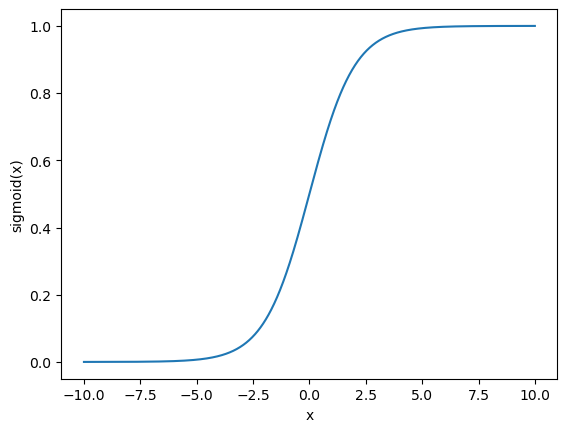

In [15]:
def sigmoid(z: torch.Tensor) -> torch.Tensor:
  ### your code here
    # z = 1/(1 + torch.exp(-x))
    return 1/(1 + torch.exp(-z))


x = torch.arange(1,2000, 1)/100.0 - 10
y = sigmoid(x)
fig, ax1 = plt.subplots()
ax1.plot(x, y)
# set label of horizontal axis
ax1.set_xlabel('x')
# set label of vertical axis
ax1.set_ylabel('sigmoid(x)')
plt.show()

In [16]:
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)
  
  def forward(self, x):
    y = 0
    ### your code here
    a =  torch.matmul(x,self.weight.t())
    y = 1/(1+torch.exp(-a))
    return y

The cost function we will use for logistic regression is the **Cross Entropy Loss**, which is given by the form:

$J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ \left(- y^{(i)} log( h_{\theta}(x^{(i)})) - (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))    \right) \right] $

Which when taking partial derivatives and putting these into the gradient descent update equation gives


$
 \theta_{j} =  \theta_{j} - \alpha \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} 
$



In [17]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
  ### your code here
    J = sum((-y_true*(torch.log(y_pred)))-((1-y_true)*(torch.log(1-y_pred))))/len(y_pred)
    return J
def gradient_descent_step(model: nn.Module, X: torch.Tensor,y_pred: torch.Tensor, y: torch.Tensor, lr: float) -> None:
  weight = model.weight
  N = X.shape[0]
  ### your code here
  ###
   
  w1 = (1/N)*sum(X*(y_pred-y))
 
  weight = weight - lr*w1
  model.weight = nn.Parameter(weight, requires_grad=False)
  #return weight

/opt/conda/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/opt/conda/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


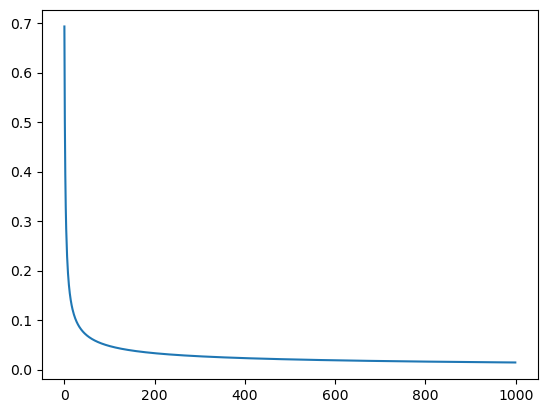

Parameter containing:
tensor([[-7.6483,  4.1452, -4.5710]])
Minimum cost: tensor([0.0143])


In [18]:
def train(model, x, y, alpha):
  cost_lst = list()
  for it in range(1000):
    prediction = model(x)
    cost = bce(y, prediction)
    cost_lst.append(cost)
    gradient_descent_step(model, x, prediction,y, alpha)
  display.clear_output(wait=True)
  plt.plot(list(range(it+1)), cost_lst)
  plt.show()
  print(model.weight)
  print('Minimum cost: {}'.format(min(cost_lst)))

model = LogisticRegression(train_set_1.shape[1])
alpha = 1 # select an appropriate lr
train(model, train_set_1, setosa_train, alpha)

 Decision boundary

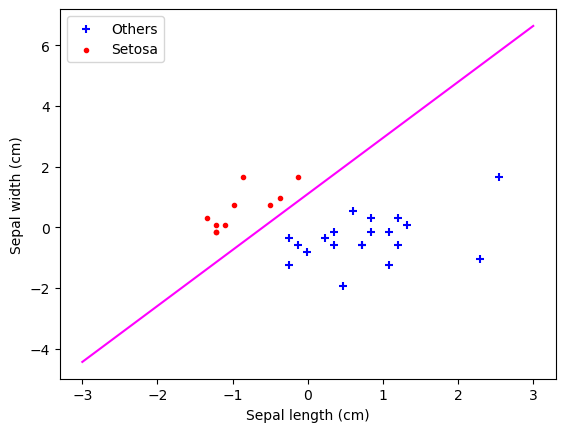

In [20]:
length = test_set_1[:, 0] 
width = test_set_1[:, 1] 
marker_list = ['.', 'x']
fig , ax=plt.subplots(1)

for i in range(setosa_test.shape[0]):
    if setosa_test[i,0] ==1:
        ax.scatter(length[i],width[i],marker='.',color = 'r')
    else:
        ax.scatter(length[i],width[i],marker='+',color = 'b')
        
w0=model.weight[:,2]
w1=model.weight[:,0]
w2=model.weight[:,1]

constant = -w0/w2
m_slope = -w1/w2

x_co_ordinate = np.array([-3, 3])
y_co_ordinate = m_slope*x_co_ordinate + constant

ax.legend(['Others','Setosa'])
ax.set(xlabel = 'Sepal length (cm)',ylabel = 'Sepal width (cm)')
ax.plot(x_co_ordinate,y_co_ordinate, color='magenta')
fig.show()
# print(y_co_ordinate)

## 2. Multiclass
So far, we have focused on a binary classification (is this iris setosa or not), however in this section we will address the problem as a multiclass classification. We will be using a 1 vs. all approach  We will also be using all 4 attributes for the classification.

Firstly, we need to process `y_train, y_test` so that each label is a vector rather than an integer. 

In [22]:
y_train = F.one_hot(y_train.reshape(-1).long(), num_classes=3)
y_test = F.one_hot(y_test.reshape(-1).long(), num_classes=3)


In this section we will use the built in pytorch methods.


In [24]:
alpha = 0.1
setosa_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
setosa_labels = y_train[:, 0].reshape(-1, 1).float()
setosa_testy = y_test[:, 0].reshape(-1, 1).float()
optimiser = optim.SGD(setosa_model.parameters(), alpha)

def train(model, x, y, test_x, test_y, optimiser, alpha):
  train_lst = list()
  test_lst = list()
  for i in range(1000):
    model.train()
    optimiser.zero_grad()
    pred = model(x)
    cost = F.binary_cross_entropy(pred, y, reduction='mean')
    cost.backward()
    train_lst.append(cost.item())
    optimiser.step()
    model.eval()
    with torch.no_grad():
      test_pred = model(test_x)
      test_cost = F.binary_cross_entropy(test_pred, test_y, reduction='mean')
      test_lst.append(test_cost)
  fig, axs = plt.subplots(2)
  axs[0].plot(list(range(i+1)), train_lst)
  axs[1].plot(list(range(i+1)), test_lst)
  plt.show()
  print('Minimum train cost: {}'.format(min(train_lst)))
  print('Minimum test cost: {}'.format(min(test_lst)))

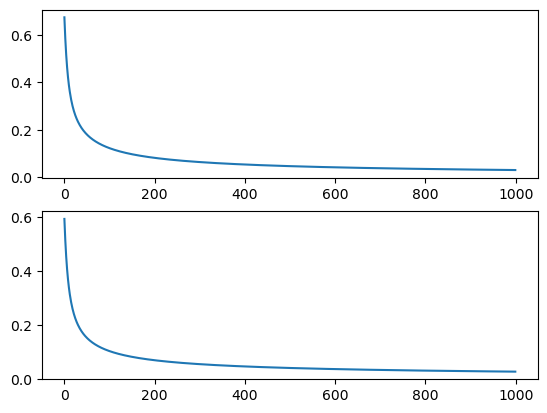

Minimum train cost: 0.03114391304552555
Minimum test cost: 0.02675635740160942


In [25]:
train(setosa_model, x_train, setosa_labels, x_test, setosa_testy, optimiser, alpha)
prediction_setosa= setosa_model(x_test)

How does the cost of the 4 attribute model compare to the previous one?



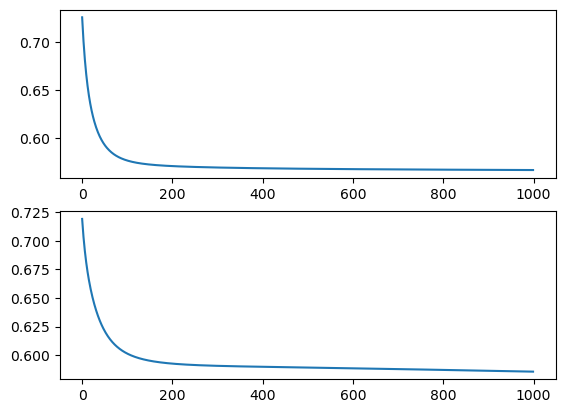

Minimum train cost: 0.5664233565330505
Minimum test cost: 0.5856663584709167


In [26]:
alpha = 0.1
versicolor_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
versicolor_labels = y_train[:, 1].reshape(-1, 1).float()
versicolor_testy = y_test[:, 1].reshape(-1, 1).float()
optimiser = optim.SGD(versicolor_model.parameters(), alpha)
train(versicolor_model, x_train, versicolor_labels, x_test, versicolor_testy, optimiser, alpha)
prediction_versicolor = versicolor_model(x_test)

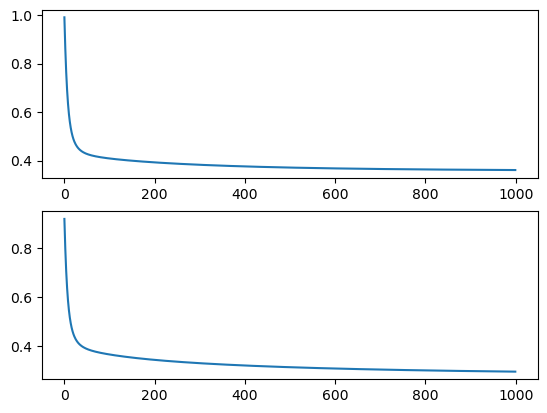

Minimum train cost: 0.36117684841156006
Minimum test cost: 0.2935484051704407


In [27]:


alpha = 0.1
virginica_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
virginica_labels = y_train[:, 2].reshape(-1, 1).float()
virginica_testy = y_test[:, 2].reshape(-1, 1).float()
optimiser = optim.SGD(virginica_model.parameters(), alpha)

train(virginica_model, x_train, virginica_labels, x_test, virginica_testy, optimiser, alpha)
prediction_virginica= virginica_model(x_test)

Using the 3 classifiers, predicting the classes of the samples in the test set and showing the predictions in a table. 

In [29]:
import pandas as pd
data =[]
data1 =[]

columns = ["Setosa", "Versicolor", "Virginica"]

for i in range  (prediction_setosa.shape[0]):
       
    data=float(prediction_setosa[i]), float(prediction_versicolor[i]), float(prediction_virginica[i])
    data1.append(data) 
table = pd.DataFrame(data=data1,  columns=columns)
# print(table)
table.head(30)

,Setosa,Versicolor,Virginica
0,0.037104,0.755961,0.456744
1,0.999964,0.169556,0.111677
2,0.000004,0.840211,0.947246
3,0.037222,0.591380,0.705244
4,0.010097,0.767673,0.538118
5,0.999699,0.303999,0.082442
6,0.276848,0.539556,0.528856
7,0.001963,0.349519,0.969116
8,0.000564,0.912007,0.393052
9,0.082495,0.732669,0.375035


<font color="maroon">  Calculation of  the accuracy of the classifier on the test set, by comparing the predicted values against the ground truth. Using a softmax for the classifier outputs.

In [30]:

accuracy_data = nn.Softmax(dim=1)(torch.column_stack((prediction_setosa, prediction_versicolor,prediction_virginica)))
# print(accuracy_data)
predicted = []
true =[]
for i in range (accuracy_data.shape[0]):
    p = int(torch.argmax(accuracy_data[i]))
    predicted.append(p)
for i in range (y_test.shape[0]):
    t = int(torch.argmax(y_test[i]))
    true.append(t)

accuracy = accuracy_score(predicted,true)
print('\nAccuarcy is {} %  '.format(accuracy*100),'\n')

ground_truth_data =[]


columns = ["True Values","Predicted Values"]

for i in range  (prediction_setosa.shape[0]):
       
    temp= true[i], predicted[i]
    ground_truth_data.append(temp) 
table = pd.DataFrame(data=ground_truth_data,  columns=columns)
# print(table)
table.head(30)



Accuarcy is 90.0 %   



,True Values,Predicted Values
0,1,1
1,0,0
2,2,2
3,1,2
4,1,1
5,0,0
6,1,1
7,2,2
8,1,1
9,1,1
